# Volumetry Analysis
## Data: 
    - 1. Freesurfer results: ICV. Lh/Rh_cerebellum_gm/wm (generated by "collect_volumes.sh" script);
        - Left/ Right cerebellum gray/white matter volumes 
    - 2. Cerebellar SUIT segmentation with SUIT and MDTB atlas; 
         - SUIT: Vermis VI, Vermis_CrusI,  Vermis_CrusII, CrusI, CrusII, Dentate nucleus;
         - MBTB: MDTB functional regions 1,2,4,5;
    - 3. Cerebellar MAGeTBrain [MAGeTBrain pipeline](https://github.com/CobraLab/documentation/wiki/MAGeTBrain#collecting-volumes)
        - MAGeT: Vermis VI, Vermis_CrusI,  Vermis_CrusII, CrusI, CrusII, Dentate nucleus;

## Cohorts
- Current cohort: MNI ET/NC (38/32), QC not included.

## Tasks
- Compare total cerebellar volumes (left and right)
- Compare lobule volumes (13 per hemisphere)

## Covariates
- Age, Sex, site, eTIV

In [1]:
## read demographic data and freesurfer outputs
from pathlib import Path
import nipype.interfaces.io as nio
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data_dir = Path("/codes/tab_data")
mni_file  = data_dir/'MNI_Des-cere_preped.csv'
adni_ppmi_file = data_dir/'ADNI-PPMI_Des-cere_preped.csv'

mni_df       = pd.read_csv(mni_file , sep=',', header=0, index_col=0);
adni_ppmi_df = pd.read_csv(adni_ppmi_file , sep=',', header=0, index_col=0);

#excluding list
data_df = pd.concat([mni_df, adni_ppmi_df])
drop_col_list = ['Left_WM_hypointensities', 'Right_WM_hypointensities', '5th_Ventricle'];
data_df=data_df.drop(columns=drop_col_list);

211008-06:12:49,383 nipype.utils WARNING:
	 A newer version (1.5.1) of nipy/nipype is available. You are using 1.5.0


In [2]:
# prepare data for this script
SUIT_labels = ['Left_I_IV','Right_I_IV','Left_V','Right_V','Left_VI','Vermis_VI','Right_VI','Left_CrusI','Vermis_CrusI','Right_CrusI','Left_CrusII','Vermis_CrusII','Right_CrusII','Left_VIIb','Vermis_VIIb','Right_VIIb','Left_VIIIa','Vermis_VIIIa','Right_VIIIa','Left_VIIIb','Vermis_VIIIb','Right_VIIIb','Left_IX','Vermis_IX','Right_IX','Left_X','Vermis_X','Right_X','Left_Dentate','Right_Dentate','Left_Interposed','Right_Interposed','Left_Fastigial','Right_Fastigial'];
SUIT_labels = [ x.replace('-','_') for x in SUIT_labels]
SUIT_l_labels = ['Left_I_IV',  'Left_V', 'Left_VI', 'Left_CrusI', 'Left_CrusII', 'Left_VIIb', 'Left_VIIIa', 'Left_VIIIb', 'Left_IX', 'Left_X', 'Left_Dentate', 'Left_Interposed', 'Left_Fastigial'];
SUIT_r_labels = ['Right_I_IV','Right_V','Right_VI','Right_CrusI','Right_CrusII','Right_VIIb','Right_VIIIa','Right_VIIIb','Right_IX','Right_X','Right_Dentate','Right_Interposed','Right_Fastigial'];
SUIT_v_labels = ['Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Vermis_VIIb', 'Vermis_VIIIa','Vermis_VIIIb', 'Vermis_IX', 'Vermis_X'];
MDTB_labels   = ['MDTB_'+str(x+1) for x in range(10)];
analysis_list = ['age','sex','group','site','eTIV','SupraTentorialVol', 'SupraTentorialVolNotVent',
                 'Left_Cerebellum_White_Matter','Left_Cerebellum_Cortex','Right_Cerebellum_White_Matter','Right_Cerebellum_Cortex']+SUIT_l_labels+SUIT_r_labels+SUIT_v_labels+MDTB_labels
curr_df = data_df.loc[:,analysis_list]
curr_df.loc[:,'Cerebellum_White_Matter']=curr_df['Left_Cerebellum_White_Matter']+curr_df['Right_Cerebellum_White_Matter'];
curr_df.loc[:,'Cerebellum_Cortex']=curr_df['Left_Cerebellum_Cortex']+curr_df['Right_Cerebellum_Cortex'];
curr_df.loc[:,'cerebellumVol']=curr_df['Cerebellum_Cortex']+curr_df['Cerebellum_White_Matter']
# calculate the Infra tentorial volumen approximately by eTIV-SupraTentorialVol
curr_df.loc[:,'InfraTentorialVol']=curr_df['eTIV']-curr_df['SupraTentorialVol']
curr_df.loc[:,'male']=[int(x=='M') for x in curr_df['sex']]


In [3]:
### statistical analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils_et_biomarker.utils import ctr_tiv, glm_test, rep_model, ctr_by_nc, cal_es,creat_Bonf_df

# get the MNI dataset for ET/NC analysis
df = curr_df[(curr_df['group']=='ET')|(curr_df['group']=='NC')].copy()

# get all 3 datasets for ET/NC analysis
df_all=curr_df.copy()
df_all.loc[:,'is_mni'] =[1 if int(x=='ET' or x=='NC') else 0 for x in df_all['group']]
df_all.loc[:,'is_ppmi']=[int(x=='PPMI') for x in df_all['group']]
df_all.loc[:,'is_adni']=[int(x=='ADNI') for x in df_all['group']]
df_all.loc[:,'group']  =[x if x=='ET' else 'NC' for x in df_all['group']]

# get indicator variable
alpha_=5; n_permu_=5000;

## covariates and target labels
info_list=['age','sex','group','site','eTIV','SupraTentorialVol', 'SupraTentorialVolNotVent','InfraTentorialVol']
cerebellum_list = ['Left_Cerebellum_Cortex','Left_Cerebellum_White_Matter',
                   'Right_Cerebellum_Cortex','Right_Cerebellum_White_Matter',
                   'Cerebellum_Cortex','Cerebellum_White_Matter'];
lobular_list = ['Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 
                'Left_CrusI', 'Right_CrusI', 'Left_CrusII', 'Right_CrusII','Left_Dentate', 'Right_Dentate',
                'MDTB_1', 'MDTB_2', 'MDTB_4', 'MDTB_5'];
tar_list = cerebellum_list+lobular_list;

df_n_comp=pd.DataFrame(zip(cerebellum_list+lobular_list, [4,4,4,4,2,2, 9,9,9,9,9,9,9,9,9, 4,4,4,4]), 
                       index=cerebellum_list+lobular_list, columns=['ROI','n_comp'])
sts_tests_list = ['Cohen_d', 'rank_sum']; 
group_mni_list = ['ET','NC'];

## Cerebellar volumentry for MNI ET/NC (38/32) dataset
    1. Experiment 1: without controling for any covariates;
    2. Experiment 2: control age/sex/eTIV with rm control group method;
    3. Experiment 3: control age/sex/infratentorialVolume with rm control group method;
    4. Experiment 4: control age/sex/eTIV with direct proportion adjustment method;
    5. Experiment 5: control age/sex/infratentorialVolume with direct proportion adjustment method;
    6. Experiment 6: control age/sex/cerebellumVol with rm control group method;
    7. Experiment 7: control age/sex/cerebellumVol with direct proportion adjustment method;

In [4]:
# Experiment 1: without controling for any covariates;
res_cere_gw = cal_es(df, tar_list, alpha_, n_permu_, sts_tests_list, group_mni_list, "");
# Experiment 2: control age/sex/eTIV with rm control group method;
dat_cere_gw_1, cere_gw_col_1 = ctr_tiv(df, tar_list, 'eTIV', ['age','male'], 'rm_norm')
res_cere_gw_1 = cal_es(dat_cere_gw_1, cere_gw_col_1, alpha_, n_permu_, sts_tests_list, group_mni_list,"RN with A,S,TIV");
res_cere_gw_1['ROI']=res_cere_gw_1['ROI'].map(lambda x: x[0:-14]);
# Experiment 3: control age/sex/infratentorialVolume with rm control group method;
dat_cere_gw_2, cere_gw_col_2 = ctr_tiv(df, tar_list, 'InfraTentorialVol', ['age','male'], 'rm_norm')
res_cere_gw_2 = cal_es(dat_cere_gw_2, cere_gw_col_2, alpha_, n_permu_, sts_tests_list, group_mni_list,"RN with A,S,infTV");
res_cere_gw_2['ROI']=res_cere_gw_2['ROI'].map(lambda x: x[0:-27]);
#Experiment 4: control age/sex/eTIV with direct proportion adjustment method;
dat_cere_gw_3, cere_gw_col_3 = ctr_tiv(df, tar_list, 'eTIV', ['age','male'], 'dpa')
res_cere_gw_3 = cal_es(dat_cere_gw_3, cere_gw_col_3, alpha_, n_permu_, sts_tests_list, group_mni_list,"DPA with A,S,TIV");
res_cere_gw_3['ROI']=res_cere_gw_3['ROI'].map(lambda x: x[0:-13])
#Experiment 5: control age/sex/infratentorialVolume with direct proportion adjustment method;
dat_cere_gw_4, cere_gw_col_4 = ctr_tiv(df, tar_list, 'InfraTentorialVol', ['age','male'], 'dpa')
res_cere_gw_4 = cal_es(dat_cere_gw_4, cere_gw_col_4, alpha_, n_permu_, sts_tests_list, group_mni_list,"DPA with A,S,infTV");
res_cere_gw_4['ROI']=res_cere_gw_4['ROI'].map(lambda x: x[0:-13]);
#Experiment 6: control age/sex/cerebellumVol with rm control group method;
dat_cere_gw_5, cere_gw_col_5 = ctr_tiv(df, tar_list, 'cerebellumVol', ['age','male'], 'rm_norm')
res_cere_gw_5 = cal_es(dat_cere_gw_5, cere_gw_col_5, alpha_, n_permu_, sts_tests_list, group_mni_list,"RN with A,S,Cere");
res_cere_gw_5['ROI']=res_cere_gw_5['ROI'].map(lambda x: x[0:-23]);
#Experiment 7: control age/sex/cerebellumVol with direct proportion adjustment method;
dat_cere_gw_6, cere_gw_col_6 = ctr_tiv(df, tar_list, 'cerebellumVol', ['age','male'], 'dpa')
res_cere_gw_6 = cal_es(dat_cere_gw_6, cere_gw_col_6, alpha_, n_permu_, sts_tests_list, group_mni_list,"DPA with A,S,Cere");
res_cere_gw_6['ROI']=res_cere_gw_6['ROI'].map(lambda x: x[0:-13]);
res_method_df=pd.concat([res_cere_gw, res_cere_gw_1, res_cere_gw_2, res_cere_gw_5, res_cere_gw_3, res_cere_gw_4, res_cere_gw_6])

Using  rm_norm
New columns 19 :  ['Left_Cerebellum_Cortex_eTIV_age_male', 'Left_Cerebellum_White_Matter_eTIV_age_male', 'Right_Cerebellum_Cortex_eTIV_age_male', 'Right_Cerebellum_White_Matter_eTIV_age_male', 'Cerebellum_Cortex_eTIV_age_male', 'Cerebellum_White_Matter_eTIV_age_male', 'Vermis_VI_eTIV_age_male', 'Vermis_CrusI_eTIV_age_male', 'Vermis_CrusII_eTIV_age_male', 'Left_CrusI_eTIV_age_male', 'Right_CrusI_eTIV_age_male', 'Left_CrusII_eTIV_age_male', 'Right_CrusII_eTIV_age_male', 'Left_Dentate_eTIV_age_male', 'Right_Dentate_eTIV_age_male', 'MDTB_1_eTIV_age_male', 'MDTB_2_eTIV_age_male', 'MDTB_4_eTIV_age_male', 'MDTB_5_eTIV_age_male']
Using  rm_norm
New columns 19 :  ['Left_Cerebellum_Cortex_InfraTentorialVol_age_male', 'Left_Cerebellum_White_Matter_InfraTentorialVol_age_male', 'Right_Cerebellum_Cortex_InfraTentorialVol_age_male', 'Right_Cerebellum_White_Matter_InfraTentorialVol_age_male', 'Cerebellum_Cortex_InfraTentorialVol_age_male', 'Cerebellum_White_Matter_InfraTentorialVol_age_

Text(0.5, 1.0, 'Metods sensitivity analysis for ET and NC Cerebellum Volemetry comparison for MNI cohort (full inform)')

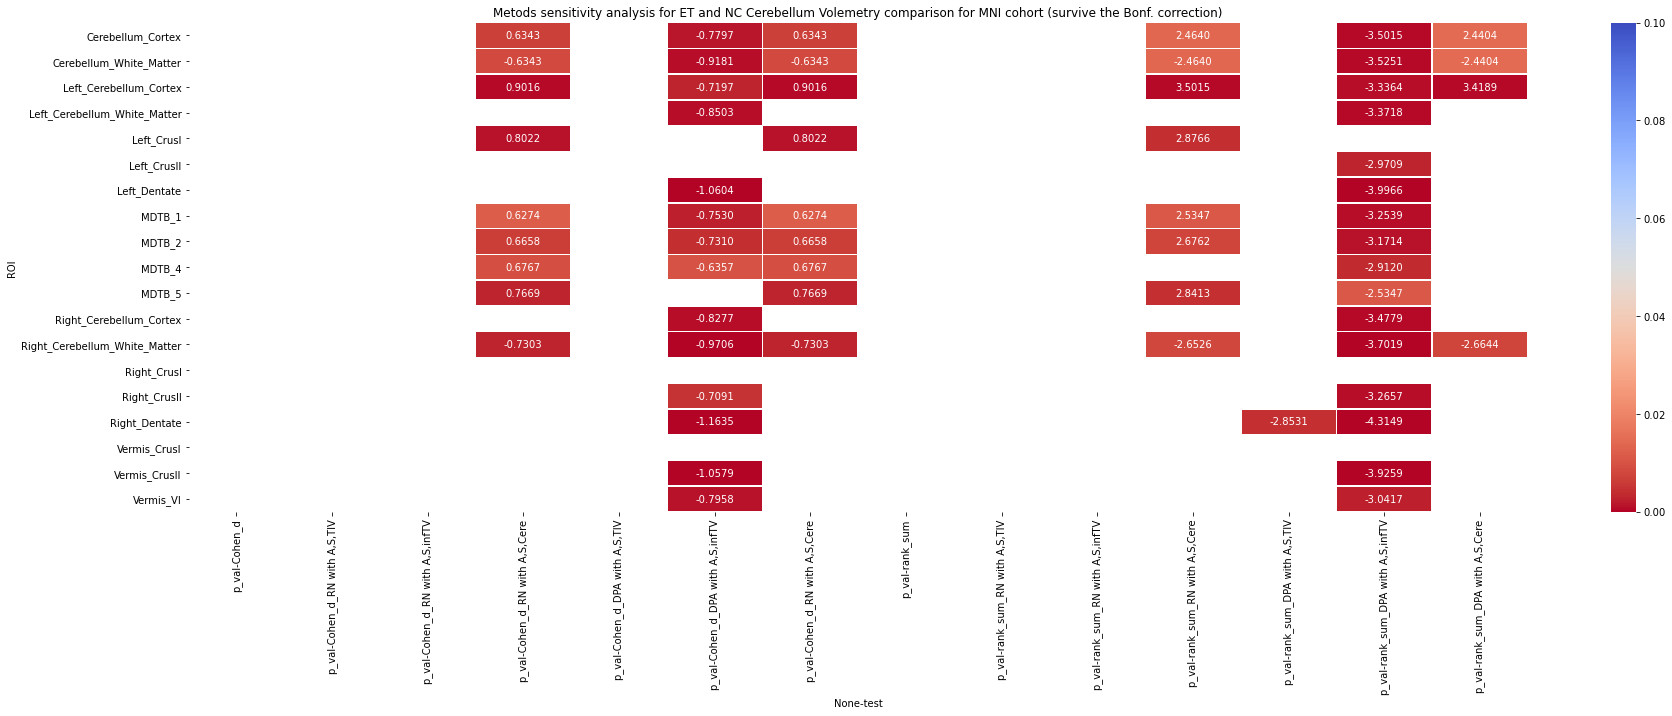

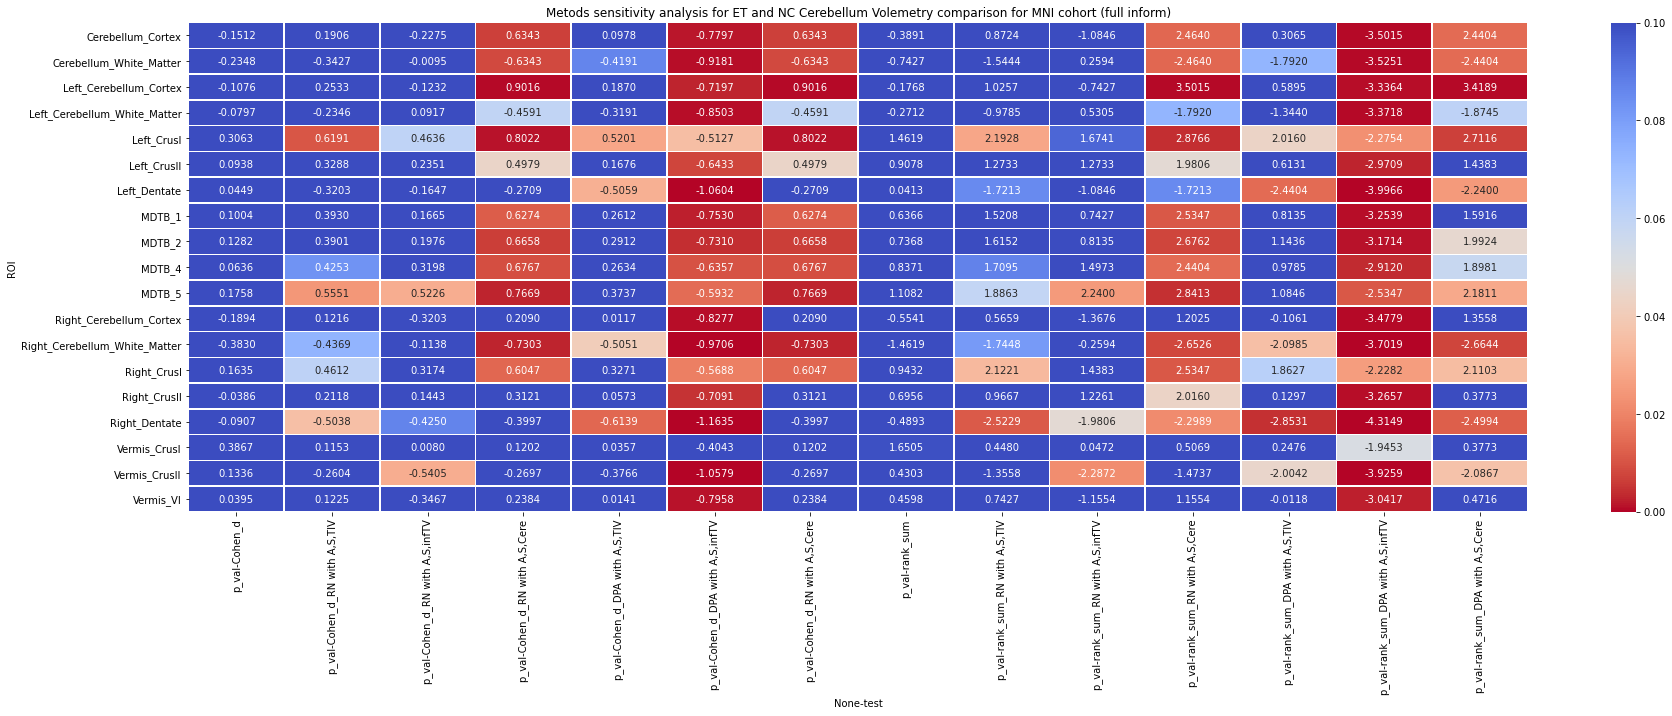

In [5]:
# Vis for methods sensitivity analysis.
C_MAP='coolwarm_r'; VMIN=0; VMAX=0.1;
order_list=['Cohen_d','Cohen_d_RN with A,S,TIV','Cohen_d_RN with A,S,infTV', 'Cohen_d_RN with A,S,Cere',  
             'Cohen_d_DPA with A,S,TIV', 'Cohen_d_DPA with A,S,infTV', 'Cohen_d_RN with A,S,Cere', 
             'rank_sum', 'rank_sum_RN with A,S,TIV', 'rank_sum_RN with A,S,infTV', 'rank_sum_RN with A,S,Cere',
             'rank_sum_DPA with A,S,TIV', 'rank_sum_DPA with A,S,infTV', 'rank_sum_DPA with A,S,Cere']

vis_df = res_method_df.copy()
es_df=vis_df[['ROI','test','ES']]; p_df=vis_df[['ROI','test','p_val']]
es_df = es_df.pivot("ROI", "test"); p_df = p_df.pivot("ROI", "test"); 

# reorder columns
es_df_=es_df[pd.MultiIndex.from_tuples([('ES', x) for x in order_list], names=[None, 'test'])]
p_df_ = p_df[pd.MultiIndex.from_tuples([('p_val', x) for x in order_list], names=[None, 'test'])]

# create multiple comparison mask
pass_df, mask_df=creat_Bonf_df(p_df_, 0.05, df_n_comp)
anno_df =pd.DataFrame(np.array(es_df_))*pd.DataFrame(np.array(1-mask_df));
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(30, 9))
ax1=sns.heatmap(p_df_, annot=anno_df, fmt=".4f", mask=mask_df,
                linewidths=.5, cmap=C_MAP, vmin=VMIN, vmax=VMAX, ax=ax)
ax1.set_title('Metods sensitivity analysis for ET and NC Cerebellum Volemetry comparison for MNI cohort (survive the Bonf. correction)')
f, ax = plt.subplots(figsize=(30, 9))
ax2=sns.heatmap(p_df_, annot=es_df_, fmt=".4f",
                linewidths=.5, cmap=C_MAP, vmin=VMIN, vmax=VMAX, ax=ax)
ax2.set_title('Metods sensitivity analysis for ET and NC Cerebellum Volemetry comparison for MNI cohort (full inform)')

## Cerebellar volumentry for all 3 datasets ET/NC(38/32+116+308)
    1. Experiment 1: without controling for any covariates;
    2. Experiment 2: control age/sex/eTIV with rm control group method;
    3. Experiment 3: control age/sex/infratentorialVolume with rm control group method;
    4. Experiment 4: control age/sex/eTIV with direct proportion adjustment method;
    5. Experiment 5: control age/sex/infratentorialVolume with direct proportion adjustment method;
    6. Experiment 6: control age/sex/cerebellumVol with rm control group method;
    7. Experiment 7: control age/sex/cerebellumVol with direct proportion adjustment method;

In [34]:
# Experiment 1: without controling for any covariates;
res_cere_gw_all = cal_es(df_all, tar_list, alpha_, n_permu_, sts_tests_list, group_mni_list, "");
# Experiment 2: control age/sex/eTIV with rm control group method;
dat_cere_gw_all_1, cere_gw_all_col_1 = ctr_tiv(df_all, tar_list, 'eTIV', ['age','male', 'is_mni','is_ppmi','is_adni'], 'rm_norm')
res_cere_gw_all_1 = cal_es(dat_cere_gw_all_1, cere_gw_all_col_1, alpha_, n_permu_, sts_tests_list, group_mni_list,"RN with A,S,TIV");
res_cere_gw_all_1['ROI']=res_cere_gw_all_1['ROI'].map(lambda x: x[0:-37]);
# Experiment 3: control age/sex/infratentorialVolume with rm control group method;
dat_cere_gw_all_2, cere_gw_col_all_2 = ctr_tiv(df_all, tar_list, 'InfraTentorialVol', ['age','male', 'is_mni','is_ppmi','is_adni'], 'rm_norm')
res_cere_gw_all_2 = cal_es(dat_cere_gw_all_2, cere_gw_col_all_2, alpha_, n_permu_, sts_tests_list, group_mni_list,"RN with A,S,infTV");
res_cere_gw_all_2['ROI']=res_cere_gw_all_2['ROI'].map(lambda x: x[0:-50]);
#Experiment 4: control age/sex/eTIV with direct proportion adjustment method;
dat_cere_gw_all_3, cere_gw_all_col_3 = ctr_tiv(df_all, tar_list, 'eTIV', ['age','male', 'is_mni','is_ppmi','is_adni'], 'dpa')
res_cere_gw_all_3 = cal_es(dat_cere_gw_all_3, cere_gw_all_col_3, alpha_, n_permu_, sts_tests_list, group_mni_list,"DPA with A,S,TIV");
res_cere_gw_all_3['ROI']=res_cere_gw_all_3['ROI'].map(lambda x: x[0:-36])
#Experiment 5: control age/sex/infratentorialVolume with direct proportion adjustment method;
dat_cere_gw_all_4, cere_gw_col_all_4 = ctr_tiv(df_all, tar_list, 'InfraTentorialVol', ['age','male', 'is_mni','is_ppmi','is_adni'], 'dpa')
res_cere_gw_all_4 = cal_es(dat_cere_gw_all_4, cere_gw_col_all_4, alpha_, n_permu_, sts_tests_list, group_mni_list,"DPA with A,S,infTV");
res_cere_gw_all_4['ROI']=res_cere_gw_all_4['ROI'].map(lambda x: x[0:-36]);
#Experiment 6: control age/sex/cerebellumVol with rm control group method;
dat_cere_gw_all_5, cere_gw_col_all_5 = ctr_tiv(df_all, tar_list, 'cerebellumVol', ['age','male', 'is_mni','is_ppmi','is_adni'], 'rm_norm')
res_cere_gw_all_5 = cal_es(dat_cere_gw_all_5, cere_gw_col_all_5, alpha_, n_permu_, sts_tests_list, group_mni_list,"RN with A,S,Cere");
res_cere_gw_all_5['ROI']=res_cere_gw_all_5['ROI'].map(lambda x: x[0:-46]);
#Experiment 7: control age/sex/cerebellumVol with direct proportion adjustment method;
dat_cere_gw_all_6, cere_gw_all_col_6 = ctr_tiv(df_all, tar_list, 'cerebellumVol', ['age','male', 'is_mni','is_ppmi','is_adni'], 'dpa')
res_cere_gw_all_6 = cal_es(dat_cere_gw_all_6, cere_gw_all_col_6, alpha_, n_permu_, sts_tests_list, group_mni_list,"DPA with A,S,Cere");
res_cere_gw_all_6['ROI']=res_cere_gw_all_6['ROI'].map(lambda x: x[0:-36]);
res_method_all_df=pd.concat([res_cere_gw_all, res_cere_gw_all_1, res_cere_gw_all_2, res_cere_gw_all_5, res_cere_gw_all_3, res_cere_gw_all_4, res_cere_gw_all_6])

Using  rm_norm
New columns 19 :  ['Left_Cerebellum_Cortex_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Left_Cerebellum_White_Matter_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Right_Cerebellum_Cortex_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Right_Cerebellum_White_Matter_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Cerebellum_Cortex_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Cerebellum_White_Matter_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Vermis_VI_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Vermis_CrusI_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Vermis_CrusII_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Left_CrusI_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Right_CrusI_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Left_CrusII_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Right_CrusII_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Left_Dentate_eTIV_age_male_is_mni_is_ppmi_is_adni', 'Right_Dentate_eTIV_age_male_is_mni_is_ppmi_is_adni', 'MDTB_1_eTIV_age_male_is_mni_is_ppmi_is_adni', 'MDTB_2_eTIV_age_male_is_mni_is_ppmi_is_adni', 'MDTB_4_eTIV

Text(0.5, 1.0, 'Metods sensitivity analysis for ET and NC Cerebellum Volemetry comparison for all 3 cohorts (full inform)')

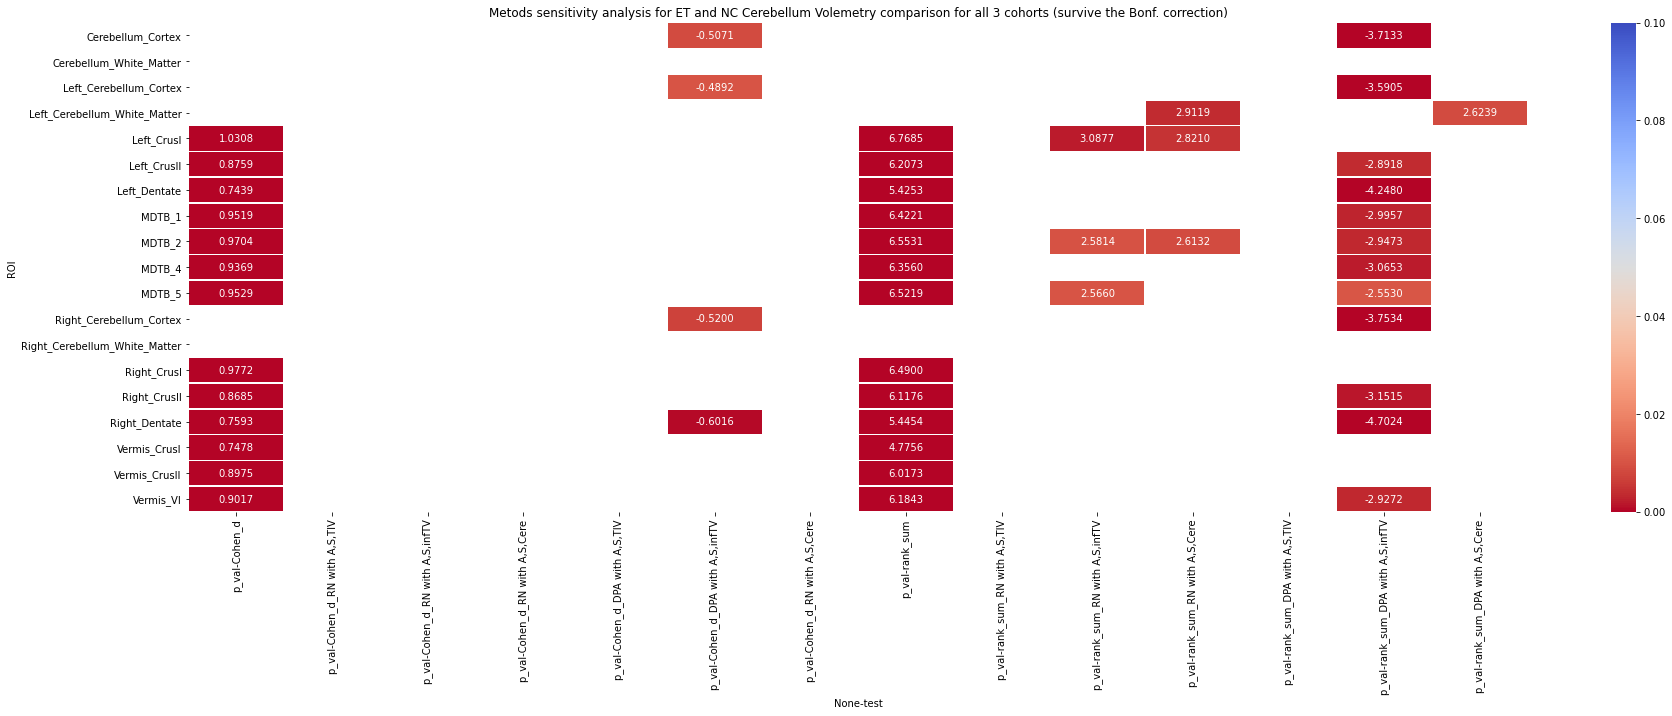

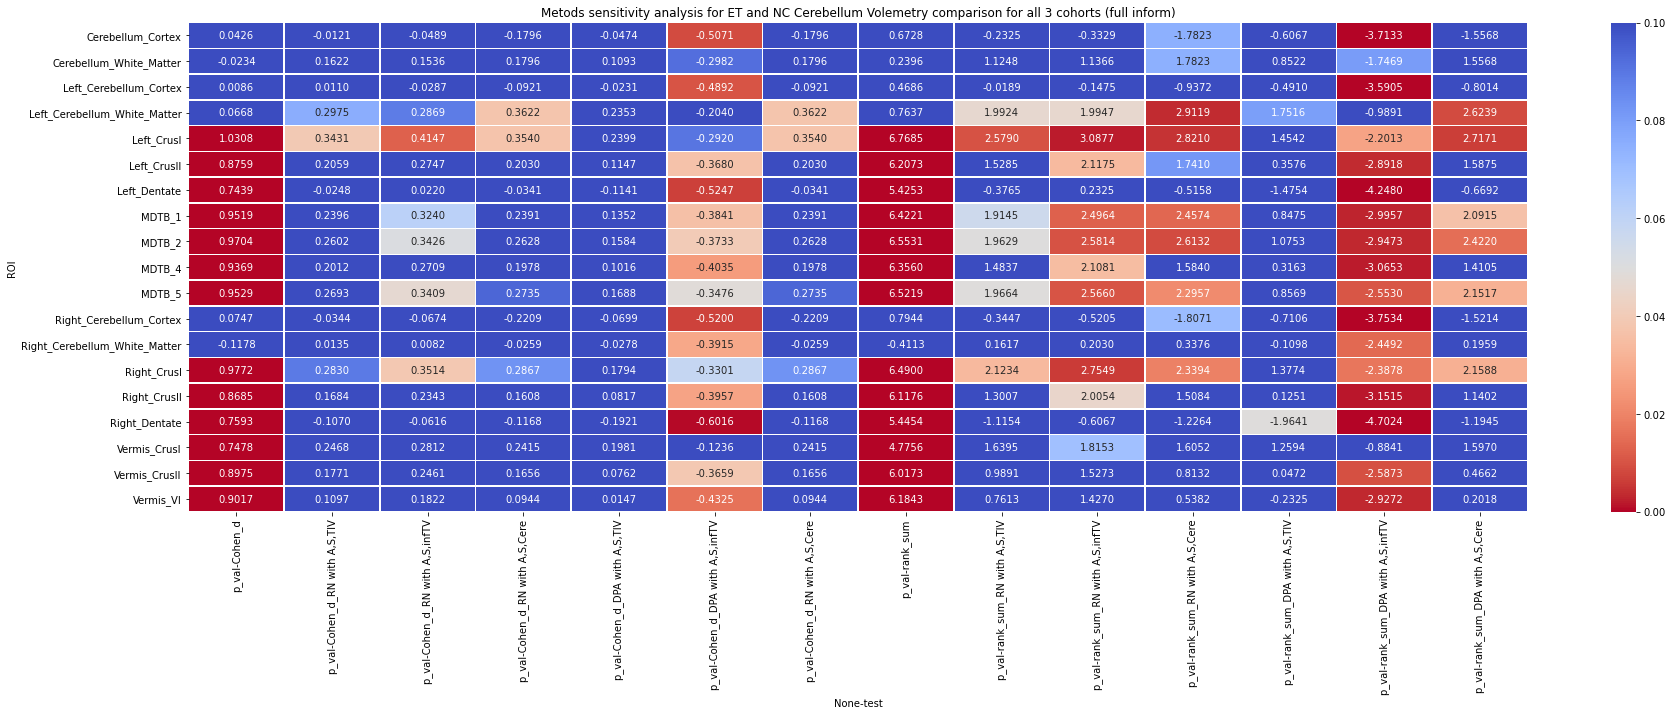

In [35]:
# Vis for methods sensitivity analysis.
C_MAP='coolwarm_r'; VMIN=0; VMAX=0.1;
order_list=['Cohen_d','Cohen_d_RN with A,S,TIV','Cohen_d_RN with A,S,infTV', 'Cohen_d_RN with A,S,Cere',  
             'Cohen_d_DPA with A,S,TIV', 'Cohen_d_DPA with A,S,infTV', 'Cohen_d_RN with A,S,Cere', 
             'rank_sum', 'rank_sum_RN with A,S,TIV', 'rank_sum_RN with A,S,infTV', 'rank_sum_RN with A,S,Cere',
             'rank_sum_DPA with A,S,TIV', 'rank_sum_DPA with A,S,infTV', 'rank_sum_DPA with A,S,Cere']

vis_df = res_method_all_df.copy()
es_df=vis_df[['ROI','test','ES']]; p_df=vis_df[['ROI','test','p_val']]
es_df = es_df.pivot("ROI", "test"); p_df = p_df.pivot("ROI", "test"); 

# reorder columns
es_df_=es_df[pd.MultiIndex.from_tuples([('ES', x) for x in order_list], names=[None, 'test'])]
p_df_ = p_df[pd.MultiIndex.from_tuples([('p_val', x) for x in order_list], names=[None, 'test'])]

# create multiple comparison mask
pass_df, mask_df=creat_Bonf_df(p_df_, 0.05, df_n_comp)
anno_df =pd.DataFrame(np.array(es_df_))*pd.DataFrame(np.array(1-mask_df));
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(30, 9))
ax1=sns.heatmap(p_df_, annot=anno_df, fmt=".4f", mask=mask_df,
                linewidths=.5, cmap=C_MAP, vmin=VMIN, vmax=VMAX, ax=ax)
ax1.set_title('Metods sensitivity analysis for ET and NC Cerebellum Volemetry comparison for all 3 cohorts (survive the Bonf. correction)')
f, ax = plt.subplots(figsize=(30, 9))
ax2=sns.heatmap(p_df_, annot=es_df_, fmt=".4f",
                linewidths=.5, cmap=C_MAP, vmin=VMIN, vmax=VMAX, ax=ax)
ax2.set_title('Metods sensitivity analysis for ET and NC Cerebellum Volemetry comparison for all 3 cohorts (full inform)')

# GLM analysis for MNI dataset

1. Testing Models: Voi=b0+b1*age+b2*sex+b3*eIV+b4*group for 'Left_Cerebellum_Cortex', 'Left_Cerebellum_White_Matter', 'Right_Cerebellum_Cortex', 'Right_Cerebellum_White_Matter'; 

2. Testing Models: Voi=b0+b1*age+b2*sex+b3*eIV+b4*group for 'Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Left_CrusI', 'Right_CrusI', 'Left_CrusII', 'Right_CrusII','Left_Dentate', 'Right_Dentate', 'MDTB_1', 'MDTB_2', 'MDTB_4', 'MDTB_5';

In [8]:
tmp_df.columns

Index(['age', 'sex', 'group', 'site', 'eTIV', 'SupraTentorialVol',
       'SupraTentorialVolNotVent', 'Left_Cerebellum_White_Matter',
       'Left_Cerebellum_Cortex', 'Right_Cerebellum_White_Matter',
       'Right_Cerebellum_Cortex', 'Left_I_IV', 'Left_V', 'Left_VI',
       'Left_CrusI', 'Left_CrusII', 'Left_VIIb', 'Left_VIIIa', 'Left_VIIIb',
       'Left_IX', 'Left_X', 'Left_Dentate', 'Left_Interposed',
       'Left_Fastigial', 'Right_I_IV', 'Right_V', 'Right_VI', 'Right_CrusI',
       'Right_CrusII', 'Right_VIIb', 'Right_VIIIa', 'Right_VIIIb', 'Right_IX',
       'Right_X', 'Right_Dentate', 'Right_Interposed', 'Right_Fastigial',
       'Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Vermis_VIIb',
       'Vermis_VIIIa', 'Vermis_VIIIb', 'Vermis_IX', 'Vermis_X', 'MDTB_1',
       'MDTB_2', 'MDTB_3', 'MDTB_4', 'MDTB_5', 'MDTB_6', 'MDTB_7', 'MDTB_8',
       'MDTB_9', 'MDTB_10', 'Cerebellum_White_Matter', 'Cerebellum_Cortex',
       'cerebellumVol', 'InfraTentorialVol', 'male'],
      dtype='

In [9]:
# GLM Model 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm
import statsmodels.stats as sts
from utils_et_biomarker.utils import glm_test, rep_model

# basic GLM
tmp_df = df.copy() 
tmp_df.loc[:,'eTIV'] = tmp_df['eTIV']-tmp_df.eTIV.mean();
tmp_df.loc[:,'cerebellumVol'] = tmp_df['cerebellumVol']-tmp_df.eTIV.mean();
tmp_df.loc[:,'InfraTentorialVol'] = tmp_df['InfraTentorialVol']-tmp_df.eTIV.mean();
for x in tar_list:
    tmp_df.loc[:,x] = (tmp_df[x]-tmp_df[x].mean())/1000;

# using eTIV as covariate
covariate_model_str = '~age+male+eTIV+C(group, Treatment(reference="NC"))';
covariate_dict = glm_test(tmp_df, tar_list, covariate_model_str);
rep_model(covariate_dict)

# using InfraTentorialVol as covariate
covariate_model_str_infra = '~age+male+InfraTentorialVol+C(group, Treatment(reference="NC"))';
covariate_dict_infra = glm_test(tmp_df, tar_list, covariate_model_str_infra);
rep_model(covariate_dict_infra)

# using cerebellumVol as covariate
covariate_model_str_cere = '~age+male+cerebellumVol+C(group, Treatment(reference="NC"))';
covariate_dict_cere = glm_test(tmp_df, tar_list, covariate_model_str_cere);
rep_model(covariate_dict_cere)



Left_Cerebellum_Cortex~age+male+eTIV+C(group, Treatment(reference="NC")) 

                            Results: Generalized linear model
Model:                      GLM                           AIC:                   369.5056
Link Function:              identity                      BIC:                   420.5880
Dependent Variable:         Left_Cerebellum_Cortex        Log-Likelihood:        -179.75 
Date:                       2021-10-08 06:24              LL-Null:               -205.80 
No. Observations:           70                            Deviance:              696.74  
Df Model:                   4                             Pearson chi2:          697.    
Df Residuals:               65                            Scale:                 10.719  
Method:                     IRLS                                                         
-----------------------------------------------------------------------------------------
                                           Coef.  S

{'Left_Cerebellum_Cortex': {'formula': 'Left_Cerebellum_Cortex~age+male+cerebellumVol+C(group, Treatment(reference="NC"))',
  'res': <statsmodels.genmod.generalized_linear_model.GLMResultsWrapper at 0x7f729f920490>},
 'Left_Cerebellum_White_Matter': {'formula': 'Left_Cerebellum_White_Matter~age+male+cerebellumVol+C(group, Treatment(reference="NC"))',
  'res': <statsmodels.genmod.generalized_linear_model.GLMResultsWrapper at 0x7f729f926430>},
 'Right_Cerebellum_Cortex': {'formula': 'Right_Cerebellum_Cortex~age+male+cerebellumVol+C(group, Treatment(reference="NC"))',
  'res': <statsmodels.genmod.generalized_linear_model.GLMResultsWrapper at 0x7f729f9134f0>},
 'Right_Cerebellum_White_Matter': {'formula': 'Right_Cerebellum_White_Matter~age+male+cerebellumVol+C(group, Treatment(reference="NC"))',
  'res': <statsmodels.genmod.generalized_linear_model.GLMResultsWrapper at 0x7f729f8c5550>},
 'Cerebellum_Cortex': {'formula': 'Cerebellum_Cortex~age+male+cerebellumVol+C(group, Treatment(reference

# GLM analysis for all 3 datasets

1. Testing Models: Voi=b0+b1*age+b2*sex+b3*eIV+b4*group for 'Left_Cerebellum_Cortex', 'Left_Cerebellum_White_Matter', 'Right_Cerebellum_Cortex', 'Right_Cerebellum_White_Matter'; 

2. Testing Models: Voi=b0+b1*age+b2*sex+b3*eIV+b4*group for 'Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Left_CrusI', 'Right_CrusI', 'Left_CrusII', 'Right_CrusII','Left_Dentate', 'Right_Dentate', 'MDTB_1', 'MDTB_2', 'MDTB_4', 'MDTB_5';

In [5]:
# GLM Model 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm
import statsmodels.stats as sts
from utils_et_biomarker.utils import glm_test, rep_model

# basic GLM
tmp_all_df = df_all.copy() 

covariate_model_all_str = '~age+male+eTIV+C(is_mni)+C(is_adni)+C(is_ppmi)+C(group, Treatment(reference="NC"))';
covariate_all_dict = glm_test(tmp_all_df, tar_list, covariate_model_all_str);
rep_model(covariate_all_dict)



Left_Cerebellum_Cortex~age+male+eTIV+C(is_mni)+C(is_adni)+C(is_ppmi)+C(group, Treatment(reference="NC")) 

                                 Results: Generalized linear model
Model:                       GLM                            AIC:                    9644.6924      
Link Function:               identity                       BIC:                    8160935032.5918
Dependent Variable:          Left_Cerebellum_Cortex         Log-Likelihood:         -4815.3        
Date:                        2021-10-08 06:14               LL-Null:                -4966.3        
No. Observations:            495                            Deviance:               8.1609e+09     
Df Model:                    6                              Pearson chi2:           8.16e+09       
Df Residuals:                488                            Scale:                  1.6723e+07     
Method:                      IRLS                                                                  
------------------------

{'Left_Cerebellum_Cortex': {'formula': 'Left_Cerebellum_Cortex~age+male+eTIV+C(is_mni)+C(is_adni)+C(is_ppmi)+C(group, Treatment(reference="NC"))',
  'res': <statsmodels.genmod.generalized_linear_model.GLMResultsWrapper at 0x7f729fd651f0>},
 'Left_Cerebellum_White_Matter': {'formula': 'Left_Cerebellum_White_Matter~age+male+eTIV+C(is_mni)+C(is_adni)+C(is_ppmi)+C(group, Treatment(reference="NC"))',
  'res': <statsmodels.genmod.generalized_linear_model.GLMResultsWrapper at 0x7f729fd0eeb0>},
 'Right_Cerebellum_Cortex': {'formula': 'Right_Cerebellum_Cortex~age+male+eTIV+C(is_mni)+C(is_adni)+C(is_ppmi)+C(group, Treatment(reference="NC"))',
  'res': <statsmodels.genmod.generalized_linear_model.GLMResultsWrapper at 0x7f72a34ef670>},
 'Right_Cerebellum_White_Matter': {'formula': 'Right_Cerebellum_White_Matter~age+male+eTIV+C(is_mni)+C(is_adni)+C(is_ppmi)+C(group, Treatment(reference="NC"))',
  'res': <statsmodels.genmod.generalized_linear_model.GLMResultsWrapper at 0x7f729fd2e6a0>},
 'Cerebellum